# <center>Assignment 1</center>

This assignment is on Nearest Neighbors. It is preferred that you code in Python3. All the imports made in this notebook are as below; if these imports work, you are (mostly) set to complete the assignment.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier as KNC
import time

<table>
  <tr>
    <td>**Section**</td>
    <td>**Score**</td>
  </tr>
  <tr>
    <td> Short-answer questions </td>
    <td> 7 </td>
  </tr>
  <tr>
    <td> MNIST data preprocessing </td>
    <td> 10 </td>
  </tr>
  <tr>
    <td> KNN Classifier </td>
    <td> 25 </td>
  </tr>
    <tr>
    <td> Cross-validation </td>
    <td> 5 </td>
  </tr>
      <tr>
    <td> KNN on Synthetic Dataset </td>
    <td> 23 </td>
  </tr>
     <tr>
    <td> Analyzing performance on MNIST  </td>
    <td> 15 </td>
  </tr>
  <tr>
    <td> **Total**  </td>
    <td> **85** </td>
  </tr>
  </table>

## 1. Short-answer questions [1+2+1+3]
Answer very briefly. [Ideally, 1 line per question.]

* Fill in the blank: K-NN is ____ (parameterized/non-parameterized). 

<b>Answer:</b> *Non-parameterized*


* "KNN algorithm works best if the data is normalized (zero-mean and unit variance)". Why? <br>
    - For MNIST, do we need to normalize? Why/why not?

<b>Answer:</b>  *KNN Algorithm works on distance so in case if the units are different of the features(units of axis on which points are plotted) then it wouldn't give proper results. So the data is normalized to get proper positioning of the data points and in turn more accurate classification.<br/>
In case of MNIST data set it isn't required to normalize the data because the features are the pixel value so the measuring unit is same accross all dimensions.* 

* "Data is partitioned into Training, Validation and Test Datasets." What is the Validation dataset used for?

<b>Answer:</b> *Validation Dataset is used to evaluate how well the model generalizes(if the model performs well on valid dataset) and to select the best model with hyper parameters(Example: selecting ideal value of k in K-NN)*.

* What is cross-validation? When is cross-validation done? How does this relate to Validation Dataset?

<b>Answer:</b> *To divide the train data into k equal parts and use one portion of k as validation data and other as train data, repeat this by changing valid dataset to other portion of dataset from k parts is cross validation.<br/> Cross validation is useful when we do not want reduce the number of samples by splitting the data into three parts: train,valid and test.<br/> Cross Validation is related to validation as it performs validations with k different sample of data and find the deviation in the accuracy.Hence, is a better way of model evaluation(underfitting/overfitting/how well it generalizes).*

## 2. MNIST data

Let's load the MNIST dataset and inspect it.

In [0]:
mnist = tf.keras.datasets.mnist
(train_data,train_labels),(test_data,test_labels) = mnist.load_data()
image_test = test_data
image_train = train_data
print("Number of training examples\t",len(train_data))
print("Number of test instances\t",len(test_data))
print("Shape of train_data\t\t",train_data.shape)
print("Shape of train_labels\t\t",train_labels.shape)
print("Shape of test_data\t\t",test_data.shape)
print("Shape of test_labels\t\t",test_labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
Number of training examples	 60000
Number of test instances	 10000
Shape of train_data		 (60000, 28, 28)
Shape of train_labels		 (60000,)
Shape of test_data		 (10000, 28, 28)
Shape of test_labels		 (10000,)


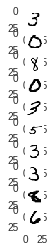

In [0]:
# Randomly choose 10 images from first 1000 images of Train Data.
for index,idx in enumerate(random.sample(range(1000),10)): 
    plt.subplot(10,1,index+1)
    plt.imshow(train_data[idx],cmap="Greys")

In [0]:
# 5 points
# Flatten the train_data and test_data for faster computation.
train_len,train_row,train_col = train_data.shape
test_len,test_row,test_col = test_data.shape
train_data = train_data.reshape([train_len, train_row*train_col])
test_data = test_data.reshape([test_len, test_row*test_col])
# If the datatype of the above arrays is int8, convert them to float/int 32/64.
train_data = train_data.astype(np.float)
test_data = test_data.astype(np.float)

print("--After Flattening and converting datatype--")
print("Shape of train_data\t\t",train_data.shape)
print("Shape of test_data\t\t",test_data.shape)
print("Data type of train nparray\t",train_data.dtype)
print("Data type test nparray\t\t",test_data.dtype)

--After Flattening and converting datatype--
Shape of train_data		 (60000, 784)
Shape of test_data		 (10000, 784)
Data type of train nparray	 float64
Data type test nparray		 float64


Find out why we need to convert from int8 to float/int 32/64. [5 pts]

<b>Answer: </b>
x = np.array([200],dtype=np.float)<br/>
y = np.array([136],dtype=np.float)<br/>
print(np.dot(x,y))<br/>
Output: 27200.0 <br/>
x = np.array([200],dtype=np.int8)<br/>
y = np.array([136],dtype=np.int8)<br/>
print(np.dot(x,y)) <br/>
Output: 64<br/>

<b>As uint8	unsigned integer ranges from  0 to 255.So, when the output of dot product for calculating the distances is larger number then it tries to adjust it in this range due to which we don't get proper distances and prediction is not accurate which will inturn give very low accuracy for the model.<b>


## 3. KNN Classifier [25 pts]

Hint: In order to compute Euclidean Distance efficiently, you can use:
$$|| x - y||_2 = x.x^T -2x.y + y.y^T$$

In [0]:
#Reference: https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/neighbors/classification.py#L23
class KNN:                                                                                                                                                                    
    def __init__(self, k, num_classes):                                                                                                                                       
        self.num_classes = num_classes                                                                                                                                        
        self.k = k                                                                                                                                                            
        self.parameters = None                                                                                                                                                
    
    def distance_batch(self, data):  # M x 784; N x 784                                                                                                                       
        """                                                                                                                                                                   
        Find the distance between M instances of data and N instances of training_data.                                                                                       
        data.shape = M,D and training_data.shape= N,D                                                                                                                         
        The fastest way to find euclidean distance between x and y is described above.                                                                                        
        Observe that x[train] is constant and y [test] is variable.                                                                                                           
        """                                                                                                                                                                   
        #np array of 100x784                                                                                                                                                  
        test_points = data                                                                                                                                                    
        # np array of 60000x784                                                                                                                                               
        train_points = self.parameters[0]                                                                                                                                     
        # train data and creating a row matrix to add to 2xy                                                                                                                  
        xxt = np.einsum('ij,ij->i', train_points, train_points)[np.newaxis, :]                                                                                                
        # test data and creating a col matrix to add to 2xy                                                                                                                   
        yyt = np.einsum('ij,ij->i', test_points, test_points)[:, np.newaxis]                                                                                                  
        # for dot product of train and test need to transpose train so we have 100 by 60000 matrix                                                                            
        xyt = np.dot(test_points, np.transpose(train_points))                                                                                                                 
        # calculating the distance                                                                                                                                            
        distance_all = np.add(np.add(np.multiply(-2, xyt), xxt), yyt)                                                                                                         
        # retruning the matrix of distances of each test point with respect to training points                                                                                
        return distance_all                                                                                                                                                   
                                                                                                                                                                              
    def train(self, training_data, training_labels):                                                                                                                          
        """                                                                                                                                                                   
        Train the classifier using the training data and training labels.                                                                                                     
        Hint: Look at Q1 in Review Questions.                                                                                                                                 
        * Store whatever is neccessary in self.parameters.                                                                                                                    
        * Do whatever pre-computation you think is neccessary to make the distance_batch function run fast.                                                                   
        """                                                                                                                                                                   
        #set the traindata and labels in parameters so that it could be refered while predicting                                                                              
        self.parameters = (training_data, training_labels)                                                                                                                    
                                                                                                                                                                              
    def predict(self, data):                                                                                                                                                  
        """                                                                                                                                                                   
        Make use of the trained parameters to predict the class.                                                                                                              
        Return the most probable class.                                                                                                                                       
        Make use of the predict_proba function.                                                                                                                               
        Hint: np.argmax will be useful.                                                                                                                                       
        """                                                                                                                                                                   
        probablities = self.predict_proba(data)                                                                                                                               
        return np.argmax(probablities,axis=1).T                                                                                                                               
                                                                                                                                                                              
    def predict_proba(self, data):                                                                                                                                            
        """                                                                                                                                                                   
        For each data point, predict the assigned class probabilities.                                                                                                        
        For faster sorting, use np.argpartition.                                                                                                                              
        """                                                                                                                                                                   
        # get distance of all test points from all the training points                                                                                                        
        dist_arr = self.distance_batch(data)                                                                                                                                  
        # get the sorted index of the column into the array                                                                                                                   
        train_idx = np.argpartition(dist_arr, self.k - 1, axis=1)                                                                                                             
        #sample array                                                                                                                                                         
        sample_arr = np.arange(dist_arr.shape[0])[:, None]                                                                                                                    
        # argpartition doesn't guarantee sorted order, but it isn't required to sort from top k elements                                                                      
        #train_idx = np.take(train_idx, np.argsort(np.take(dist_arr, train_idx)))                                                                                             
        # for setting results for top k indices of train point for each test point                                                                                            
        train_idx = train_idx[:, :self.k] 
        #final_data = np.sqrt(np.take(dist_arr, train_idx)), train_idx                                                                                                         
        # distance and eculidean point index                                                                                                                                  
        ed_distance, pt_idx = np.take(dist_arr, train_idx), train_idx                                                                                                                                       
        #number of distinct classes                                                                                                                                           
        target = list(sorted(set(train_labels)))                                                                                                                              
        probabilities =[]  
        #train_data class labels
        label_params = self.parameters[1].reshape((-1, 1))                                                                                                                                                                                                                                                                                          
        #set label to find which classes are nearer to the test data                                                                                                          
        k_targets = label_params[:, 0][pt_idx]                                                                                                                                
        #create an empty array of size test_data x number of target class                                                                                                     
        probablity_arr = np.zeros((data.shape[0], len(target)))                                                                                                               
        #increase each class by one in probablity array considering each class is uniformly weighted                                                                          
        for i, idx in enumerate(k_targets.T):                                                                                                                                 
            probablity_arr[np.arange(data.shape[0]),idx] += np.ones((data.shape[0],))                                                                                         
        #normalizing the probablities in the range of 0 to 1                                                                                                                  
        #sum accross all the classes for a particular test point  so it would be train points x 1                                                                             
        norm_prob = probablity_arr.sum(axis=1)[:,np.newaxis]                                                                                                                  
        #incase the sum is zero make it one to avoid divide by zero error                                                                                                     
        norm_prob[norm_prob==0.0] = 1.0                                                                                                                                       
        #divide each element by the normalizing value                                                                                                                         
        probablity_arr/=norm_prob                                                                                                                                             
        probabilities.append(probablity_arr)                                                                                                                                  
        return probabilities[0]                                                                                                                                               
                                                                                                                                                                              
    def accuracy(self, data, labels):                                                                                                                                         
        """                                                                                                                                                                   
        Returns the accuracy as a percentage computed over the data.                                                                                                          
        Already completed for you!                                                                                                                                            
        """                                                                                                                                                                   
        num_correct = 0                                                                                                                                                       
        num_seen = 0                                                                                                                                                          
        pred_labels = np.array(self.predict(data))                                                                                                                            
        return (pred_labels == labels).sum() / len(data)                                                                                                                      
                                                                                                                                                                              
                                                                                                                                                                              

Let's instatiate our KNN and the KNN provided by SkLearn. 

In [0]:
custom_knn = KNN(k=5,num_classes=10)
custom_knn.train(train_data,train_labels)

sklearn_knn = KNC(5,algorithm="brute")
sklearn_knn.fit(train_data,train_labels)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

First, we will check the accuracy <u>on first 100</u> examples of test dataset.

In [0]:
t=time.clock()
print("Custom KNN Accuracy:\t",custom_knn.accuracy(test_data[:100],test_labels[:100]))
print("Time taken:\t\t",time.clock()-t,"\n")

t=time.clock()
print("SkLearn KNN Accuracy:\t",(sklearn_knn.predict(test_data[:100])==test_labels[:100]).sum()/100)
print("Time taken:\t\t",time.clock()-t)

Custom KNN Accuracy:	 0.99
Time taken:		 1.1432910000000005 

SkLearn KNN Accuracy:	 0.99
Time taken:		 0.9189789999999993


To check correctness, we will sample 200 examples from the test dataset and compare the predict_proba methods.

In [0]:
indices = random.sample(range(len(test_data)),200)
selected_data = test_data[indices]
selected_labels = test_labels[indices]
print((np.abs(custom_knn.predict_proba(selected_data)-sklearn_knn.predict_proba(selected_data))<10**-10).all())

True


After you have completed all the methods, the output of the above cell should be <code>True</code>.

## 4. Cross-validation to choose <code>k</code>

Use SkLearn to perform <b>10-fold cross-validation</b> across different values of k [1,5,10,15,20]. Use accuracy as the metric.
    - Plot the graph of test accuracy (along with standard-deviation) for each value of k.
    - What is the ideal value of k according to your experiments?
    - How did you decide?

Tips:
* Use the KNN classifier provided SkLearn for the experiments. 
* Refer to <a href="https://scikit-learn.org/stable/modules/cross_validation.html">this</a> page for info on using cross-validation in sklearn.
* Refer to <a href="https://matplotlib.org/api/_as_gen/matplotlib.pyplot.errorbar.html">this</a> page for details on plotting graphs with error-bars.

In [0]:
# Worth 10 points
#Reference for Plotting: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import cross_val_score

def kNN_CrossVal(data,labels,ks=[1,5,10,15,20]):
    """
    Write code to generate graph of test-accuracy along with standard deviation
    as a function of the ks.
    """
    k_scores=[]
    for k in ks:
      #stratify kfold helps to ensure each label is in equal ratio in train and valid
      #shuffle_split = StratifiedShuffleSplit(n_splits=10, test_size=0.005, random_state=10)
      #model
      sklearn_knn = KNC(k,algorithm="brute")
      #10-fold Cross Validation
      scores = cross_val_score(sklearn_knn, data, labels, cv=10, scoring='accuracy')
      k_scores.append(scores)
    #print(k_scores)
    mean_list = list(np.mean(k_scores,axis=1))
    std_list = list(np.std(k_scores,axis=1))
    #calculate mean over the list of accuracy for a each k
    mean_str = ['%.3f' % elem for elem in mean_list]
    #calculate the deviation in the accuracy for a each k
    std_str = ['%.3f' % elem for elem in std_list]
    for i in range(0,len(mean_list)):
      print('K: '+str(ks[i])+' Accuracy '+str(mean_str[i])+' +/- '+str(std_str[i]))
    #plot accuracy with std for different values of k
    plt.figure()
    plt.title("Custom KNN Model")
    plt.xlabel("Ks")
    plt.xticks(ks)
    plt.ylabel("Accuracy Score")
    plt.grid()
    plt.fill_between(ks,np.subtract(mean_list,std_list), np.add(mean_list,std_list), alpha=0.1, color="g")
    plt.plot(ks, mean_list, 'o-', color="g",label="Test Accuracy")
    plt.legend(loc="best")
    plt.show()
      

K: 1 Accuracy 0.971 +/- 0.004
K: 5 Accuracy 0.970 +/- 0.004
K: 10 Accuracy 0.966 +/- 0.004
K: 15 Accuracy 0.964 +/- 0.004
K: 20 Accuracy 0.961 +/- 0.005


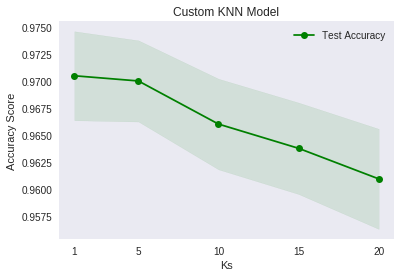

In [0]:
kNN_CrossVal(train_data,train_labels)

Comment on your observations.<br/>
<b>Answer:</b> Ideal Value of K=5.<br/>
The deviation in the accuracies is very low for all the senarios. Accuracy value for K=1 is highest but selecting k=1 might tend to overfit the model and might not generalize well.<b> K=5 has the next best accuracy score and low deviation.<b>


## 5. KNN on a synthetic dataset [5 + 5 + 13]

Complete the following functions which generate synthetic data:
* The function generator_simple generates data of <i>N</i> number_dimensions such that <code>label(X) = 0 if X<sub>0</sub> &le; 0.5 else 1</code>.
* The function generator_complex generates data of <i>N</i> number_dimensions such that <code>label(X) = 0 if X<sub>0</sub> &le; 0.5 XOR X<sub>1</sub> &le; 0.5 else 1</code>.

Note: Each of the dimensions of the data are indepedent and uniformly distributed between 0 and 1.

In [0]:
# Worth 5 points
def generator_simple(number_examples,number_dimensions):
    data = []
    labels = []
    for i in range(number_examples):
        vec_curr = np.random.uniform(0.0,1.0,number_dimensions)
        data.append(vec_curr)
        if vec_curr[0] <= 0.5:
          labels.append(0)
        else:
          labels.append(1)
    data = np.array(data)
    labels = np.array(labels)
    return data,labels

In [0]:
# Worth 5 points
def generator_complex(number_examples,number_dimensions=2):
    data = []
    labels = []
    for i in range(number_examples):
        vec_curr = np.random.uniform(0.0,1.0,number_dimensions)
        data.append(vec_curr)
        if (vec_curr[0] <= 0.5) != (vec_curr[1] <= 0.5):
          labels.append(0)
        else:
          labels.append(1)
    return data,labels

Now:
* Perform cross-fold-validation [Use kNN_CrossVal] using 1000 generated data points.
* Vary the number of dimensions and report the results.

---Simple Generator with dimensionality:2---
K: 1 Accuracy 0.986 +/- 0.011
K: 5 Accuracy 0.985 +/- 0.009
K: 10 Accuracy 0.979 +/- 0.010
K: 15 Accuracy 0.980 +/- 0.008
K: 20 Accuracy 0.984 +/- 0.013


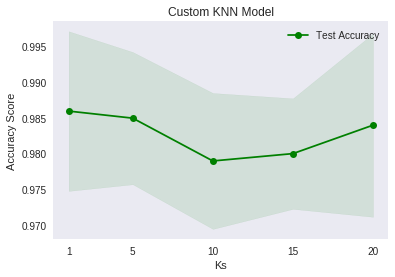

---Simple Generator with dimensionality:150---
K: 1 Accuracy 0.605 +/- 0.066
K: 5 Accuracy 0.671 +/- 0.057
K: 10 Accuracy 0.691 +/- 0.037
K: 15 Accuracy 0.700 +/- 0.057
K: 20 Accuracy 0.720 +/- 0.050


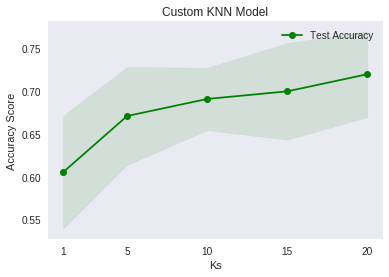

---Simple Generator with dimensionality:200---
K: 1 Accuracy 0.575 +/- 0.030
K: 5 Accuracy 0.652 +/- 0.052
K: 10 Accuracy 0.661 +/- 0.040
K: 15 Accuracy 0.707 +/- 0.057
K: 20 Accuracy 0.701 +/- 0.048


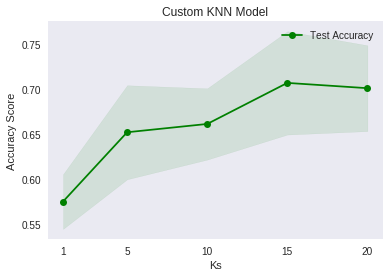

---Simple Generator with dimensionality:500---
K: 1 Accuracy 0.524 +/- 0.051
K: 5 Accuracy 0.572 +/- 0.050
K: 10 Accuracy 0.592 +/- 0.032
K: 15 Accuracy 0.619 +/- 0.056
K: 20 Accuracy 0.632 +/- 0.058


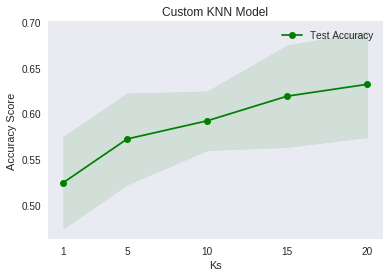

---Complex Generator with dimensionality:2---
K: 1 Accuracy 0.976 +/- 0.017
K: 5 Accuracy 0.976 +/- 0.011
K: 10 Accuracy 0.971 +/- 0.016
K: 15 Accuracy 0.973 +/- 0.020
K: 20 Accuracy 0.974 +/- 0.020


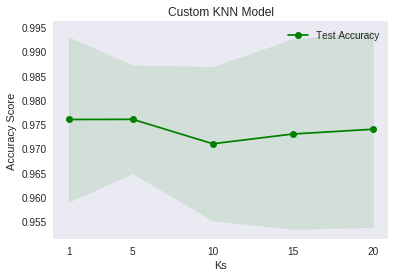

---Complex Generator with dimensionality:150---
K: 1 Accuracy 0.520 +/- 0.032
K: 5 Accuracy 0.533 +/- 0.032
K: 10 Accuracy 0.534 +/- 0.034
K: 15 Accuracy 0.540 +/- 0.036
K: 20 Accuracy 0.558 +/- 0.033


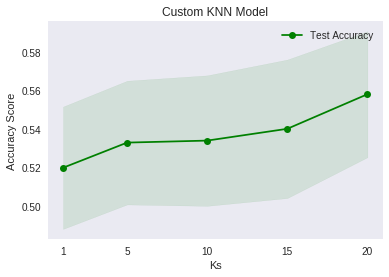

---Complex Generator with dimensionality:200---
K: 1 Accuracy 0.536 +/- 0.078
K: 5 Accuracy 0.542 +/- 0.033
K: 10 Accuracy 0.522 +/- 0.047
K: 15 Accuracy 0.556 +/- 0.055
K: 20 Accuracy 0.567 +/- 0.050


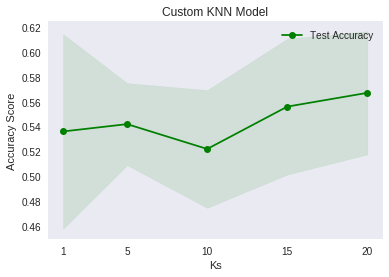

---Simple Generator with dimensionality:500---
K: 1 Accuracy 0.536 +/- 0.078
K: 5 Accuracy 0.542 +/- 0.033
K: 10 Accuracy 0.522 +/- 0.047
K: 15 Accuracy 0.556 +/- 0.055
K: 20 Accuracy 0.567 +/- 0.050


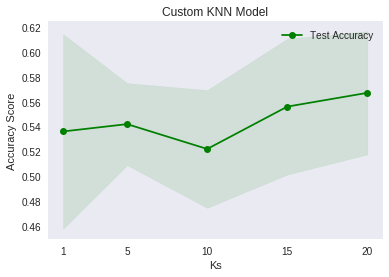

In [0]:
#cross val on simple generator with dimensionality 2,150,200
print("---Simple Generator with dimensionality:2---")
simple_data,simple_label = generator_simple(1000,2)
kNN_CrossVal(simple_data,simple_label)
print("---Simple Generator with dimensionality:150---")
simple_data,simple_label = generator_simple(1000,150)
kNN_CrossVal(simple_data,simple_label)
print("---Simple Generator with dimensionality:200---")
simple_data,simple_label = generator_simple(1000,200)
kNN_CrossVal(simple_data,simple_label)
print("---Simple Generator with dimensionality:500---")
simple_data,simple_label = generator_simple(1000,500)
kNN_CrossVal(simple_data,simple_label)

#cross val on complex generator with dimensionality 2,150,200
print("---Complex Generator with dimensionality:2---")
complex_data,complex_label = generator_complex(1000,2)
kNN_CrossVal(complex_data,complex_label)
print("---Complex Generator with dimensionality:150---")
complex_data,complex_label = generator_complex(1000,150)
kNN_CrossVal(complex_data,complex_label)
print("---Complex Generator with dimensionality:200---")
complex_data,complex_label = generator_complex(1000,200)
kNN_CrossVal(complex_data,complex_label)
print("---Simple Generator with dimensionality:500---")
simple_data,simple_label = generator_simple(1000,500)
kNN_CrossVal(complex_data,complex_label)

<b>Result Report:</b> 
- Accuracy is best for dimensionaltiy=2
- Simple Synthesized Dataset: Accuracy reduces initially with increase in dimensionality but from dimentionality 200 to 1000 it varies between 50 to 65%.
- Complex Synthesized Dataset: Accuracy reduces initially with increase in dimensionality but from dimentionality 150 to 1000  it varies around 50%. 

How does KNN perform on synthesized datasets of dimensionality of the order of those of MNIST images [784 dimensions]?
* Comment on your observations. [3 pts]
* Why is there a difference in behavior? [10 pts] <br>
[Will be good if you can you graphically compare and contrast. <b>(Possibly hard)</b>]

<b>Answer:</b> *The KNN algorithm doesn't perform well on synthesized dataset of same dimensionality as of MNIST. <br/>
Due to the vectors formed in case of <b>synthesized dataset</b> only x0 in case of simple dataset and x0 and x1 values in case of complex dataset of the vector decides the target/label.But KNN tends to calculate the distance between the vectors and as the dimensionality is increased the other dimension values do not contribute to label decision which doesn't give correct predicted label as the data isn't seperated across the dimensions.Where as in case of <b>MNIST dataset</b> the vectors are formed by pixel intensity and its the case that same digits would have nearer vectors as all the dimensions contribute to target selection. The 3D graph of points is plotted for 2 targers for simple, complex and MNIST dataset justifies how well the data is seperated.*


---Simple Generator with dimensionality:784---
K: 1 Accuracy 0.550 +/- 0.032
K: 5 Accuracy 0.572 +/- 0.042
K: 10 Accuracy 0.598 +/- 0.037
K: 15 Accuracy 0.635 +/- 0.028
K: 20 Accuracy 0.644 +/- 0.033


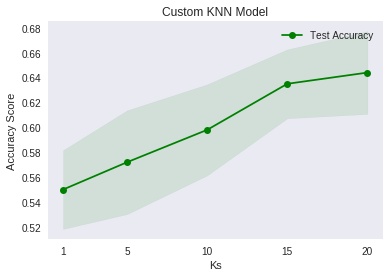

---Complex Generator with dimensionality:784---
K: 1 Accuracy 0.494 +/- 0.039
K: 5 Accuracy 0.464 +/- 0.031
K: 10 Accuracy 0.486 +/- 0.046
K: 15 Accuracy 0.498 +/- 0.051
K: 20 Accuracy 0.487 +/- 0.041


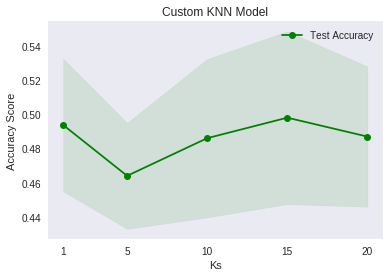

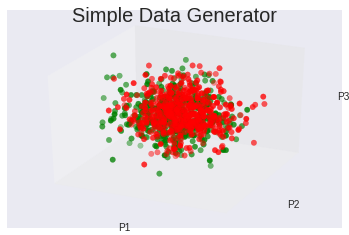

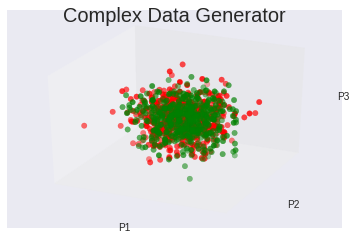

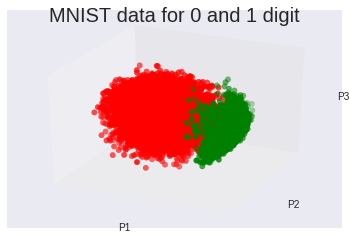

In [0]:
print("---Simple Generator with dimensionality:784---")
simple_data,simple_label = generator_simple(1000,784)
kNN_CrossVal(simple_data,simple_label)
print("---Complex Generator with dimensionality:784---")
complex_data,complex_label = generator_complex(1000,784)
kNN_CrossVal(complex_data,complex_label)

#Reference: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#Reference: https://matplotlib.org/examples/mplot3d/rotate_axes3d_demo.html
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
def plot3dGraph(points,targets,title):
    #pca is used to reduce the dimentionality
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(points)
    pca_df = pd.DataFrame(data = principalComponents , 
                               columns = ['pcax', 'pcay', 'pcaz']).reset_index(drop=True)
    final_df = pd.concat([pca_df, pd.DataFrame(targets)], axis = 1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('P1', fontsize = 10)
    ax.set_ylabel('P2', fontsize = 10)
    ax.set_zlabel('P3', fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(title, fontsize = 20)
    targets = [0,1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        selected_idx = final_df[0] == target
        ax.view_init(330, 245)
        ax.scatter(final_df.loc[selected_idx, 'pcax']
                   , final_df.loc[selected_idx, 'pcay'], final_df.loc[selected_idx, 'pcaz'], c = color, s = 30)
    plt.show()

plot3dGraph(simple_data,simple_label,"Simple Data Generator")
plot3dGraph(complex_data,complex_label,"Complex Data Generator")
plot3dGraph(train_data,train_labels,"MNIST data for 0 and 1 digit")

## 6. Analyzing performance on MNIST [15 pts]

- Analyze the images which got misclassified by KNN by showing in detail the Nearest Neighbors. Use k=5. <b>[possibly will take effort]</b>
- In order to demonstrate weaknesses, you are welcome to create new examples. [You can use any value of k in this case] 

<b>Answer:</b> The images misclassified are mostly the digits that are similar to the another number.It can be seen that images are nearer to the more data point of other label than the actual label data points which leads to misclassification.


-----For K=5-----

Actual: 4 Predicted:0


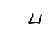

Nearest Neighbors Details:
'Digit 0': 3 'Digit 4': 2 

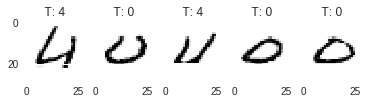


Actual: 4 Predicted:9


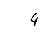

Nearest Neighbors Details:
'Digit 9': 5 

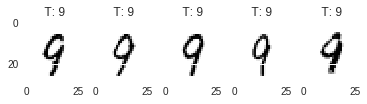


Actual: 3 Predicted:1


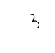

Nearest Neighbors Details:
'Digit 1': 3 'Digit 5': 2 

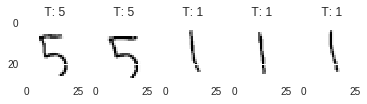


Actual: 9 Predicted:8


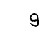

Nearest Neighbors Details:
'Digit 8': 3 'Digit 9': 2 

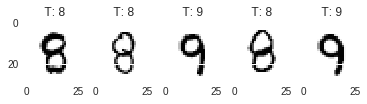


Actual: 4 Predicted:6


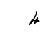

Nearest Neighbors Details:
'Digit 4': 1 'Digit 6': 4 

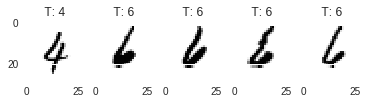


Actual: 4 Predicted:1


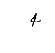

Nearest Neighbors Details:
'Digit 1': 5 

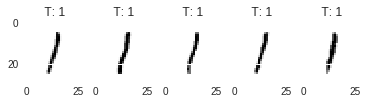


Actual: 2 Predicted:0


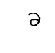

Nearest Neighbors Details:
'Digit 0': 2 'Digit 2': 1 'Digit 3': 2 

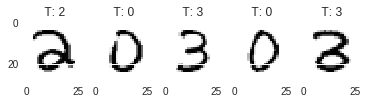


Actual: 9 Predicted:7


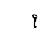

Nearest Neighbors Details:
'Digit 1': 1 'Digit 7': 3 'Digit 9': 1 

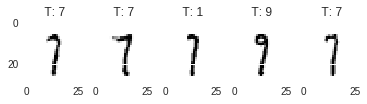


Actual: 2 Predicted:7


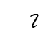

Nearest Neighbors Details:
'Digit 7': 5 

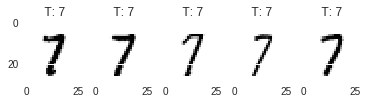


Actual: 6 Predicted:4


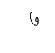

Nearest Neighbors Details:
'Digit 4': 3 'Digit 6': 1 'Digit 7': 1 

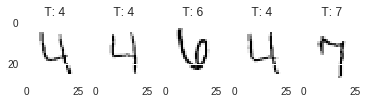


Actual: 7 Predicted:4


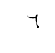

Nearest Neighbors Details:
'Digit 4': 4 'Digit 7': 1 

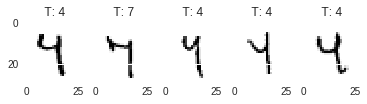


Actual: 3 Predicted:7


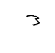

Nearest Neighbors Details:
'Digit 7': 5 

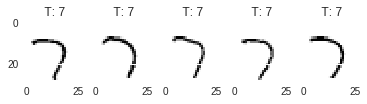


Actual: 2 Predicted:8


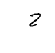

Nearest Neighbors Details:
'Digit 2': 2 'Digit 8': 3 

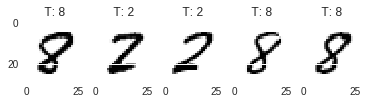


Actual: 6 Predicted:0


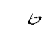

Nearest Neighbors Details:
'Digit 0': 5 

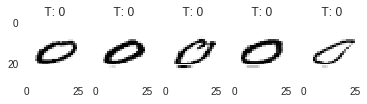


Actual: 3 Predicted:7


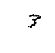

Nearest Neighbors Details:
'Digit 7': 5 

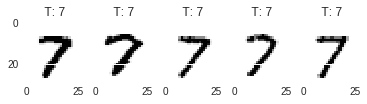


Actual: 9 Predicted:3


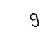

Nearest Neighbors Details:
'Digit 3': 2 'Digit 8': 1 'Digit 9': 2 

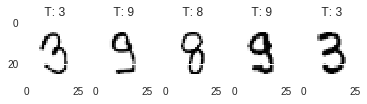


Actual: 8 Predicted:0


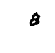

Nearest Neighbors Details:
'Digit 0': 4 'Digit 8': 1 

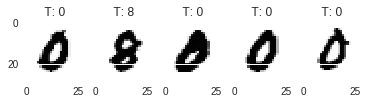


-----For K=10-----

Actual: 4 Predicted:0


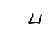

Nearest Neighbors Details:
'Digit 0': 4 'Digit 2': 1 'Digit 4': 4 'Digit 6': 1 

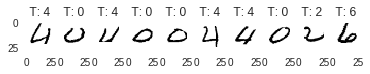


Actual: 2 Predicted:1


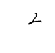

Nearest Neighbors Details:
'Digit 1': 6 'Digit 2': 4 

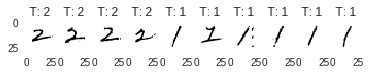


Actual: 8 Predicted:2


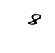

Nearest Neighbors Details:
'Digit 2': 5 'Digit 8': 5 

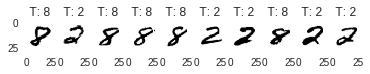


Actual: 2 Predicted:7


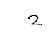

Nearest Neighbors Details:
'Digit 2': 4 'Digit 7': 6 

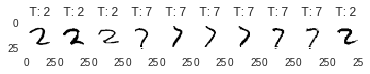


Actual: 4 Predicted:9


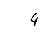

Nearest Neighbors Details:
'Digit 4': 2 'Digit 9': 8 

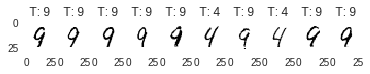


Actual: 3 Predicted:1


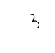

Nearest Neighbors Details:
'Digit 1': 6 'Digit 3': 2 'Digit 5': 2 

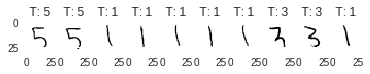


Actual: 9 Predicted:8


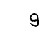

Nearest Neighbors Details:
'Digit 5': 2 'Digit 8': 4 'Digit 9': 4 

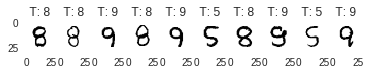


Actual: 4 Predicted:6


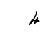

Nearest Neighbors Details:
'Digit 4': 2 'Digit 6': 8 

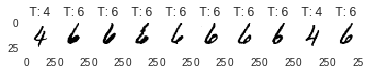


Actual: 4 Predicted:1


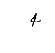

Nearest Neighbors Details:
'Digit 1': 9 'Digit 4': 1 

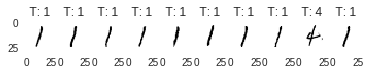


Actual: 2 Predicted:0


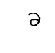

Nearest Neighbors Details:
'Digit 0': 5 'Digit 2': 2 'Digit 3': 3 

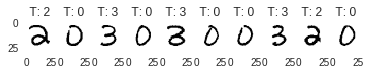


Actual: 9 Predicted:7


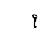

Nearest Neighbors Details:
'Digit 1': 2 'Digit 7': 5 'Digit 9': 3 

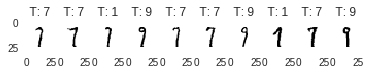


Actual: 2 Predicted:7


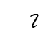

Nearest Neighbors Details:
'Digit 7': 10 

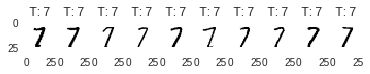


Actual: 6 Predicted:4


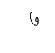

Nearest Neighbors Details:
'Digit 4': 5 'Digit 6': 2 'Digit 7': 1 'Digit 9': 2 

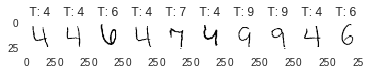


Actual: 7 Predicted:4


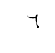

Nearest Neighbors Details:
'Digit 4': 8 'Digit 7': 1 'Digit 9': 1 

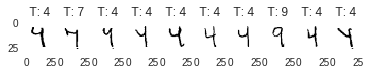


Actual: 3 Predicted:7


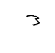

Nearest Neighbors Details:
'Digit 7': 10 

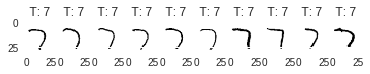


Actual: 2 Predicted:8


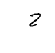

Nearest Neighbors Details:
'Digit 2': 3 'Digit 8': 7 

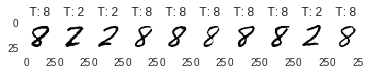


Actual: 6 Predicted:0


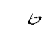

Nearest Neighbors Details:
'Digit 0': 9 'Digit 6': 1 

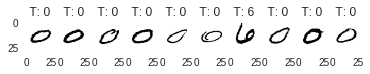


Actual: 4 Predicted:9


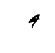

Nearest Neighbors Details:
'Digit 4': 4 'Digit 9': 6 

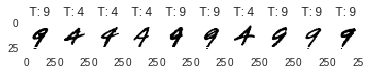


Actual: 2 Predicted:1


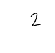

Nearest Neighbors Details:
'Digit 1': 6 'Digit 2': 4 

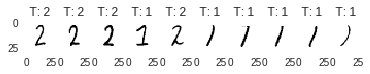


Actual: 3 Predicted:7


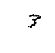

Nearest Neighbors Details:
'Digit 7': 10 

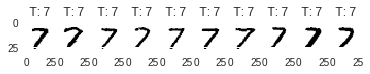


Actual: 9 Predicted:3


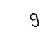

Nearest Neighbors Details:
'Digit 3': 4 'Digit 5': 1 'Digit 8': 1 'Digit 9': 4 

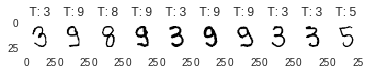


Actual: 8 Predicted:0


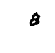

Nearest Neighbors Details:
'Digit 0': 9 'Digit 8': 1 

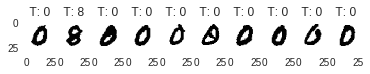

In [0]:
def plotMisClassified(clf_model,tst_dt,tst_lb,img_tst,img_trn,no_samples,k):
  predicted_arr = clf_model.predict(tst_dt)
  idx_error = []
  #fetch all the index of the labels predicted incorrectly
  for i in range(0,no_samples):
      if predicted_arr[i] != tst_lb[i]:
        idx_error.append(i)
  plt.figure()
  
  for idx in idx_error: 
      plt.subplot(10,1,1)
      #print actual and predicted labels
      print("\nActual: "+str(tst_lb[idx])+" Predicted:"+str(predicted_arr[idx]))
      #plot the digits from the index fetched above
      plt.imshow(img_tst[idx],cmap="Greys")
      plt.axis('off')
      plt.show()
      #get predicted probablity
      prob_map = clf_model.predict_proba(tst_dt[idx].reshape(1, -1))
      #get distances and indices of k nearest neighbours
      distances, indices = clf_model.kneighbors(tst_dt[idx].reshape(-1, 784))
      print("Nearest Neighbors Details:")
      for n_idx, prob in enumerate(prob_map[0]):
        if prob > 0:
          print("\'Digit "+str(n_idx)+"\': "+str(int(prob*k)), end =" ")
      #plot all the images of nearest neighbours 
      fig, axes = plt.subplots(ncols=k,nrows=1, sharex=True, sharey=True)  
      for curr_idx,trn_idx in enumerate(indices[0]):
        #print("Label: "+(str(train_labels[trn_idx])))
        axes[curr_idx].imshow(img_trn[trn_idx],cmap="Greys")
        axes[curr_idx].set_title(' T: {} '.format(train_labels[trn_idx]))
      plt.show()
      
#modify this variable to get number of test samples
no_samples = 500
print("\n-----For K=5-----")
sklearn_knn = KNC(5,algorithm="brute")
sklearn_knn.fit(train_data,train_labels)
plotMisClassified(sklearn_knn,test_data[:no_samples],test_labels[:no_samples],image_test,image_train,no_samples,k=5)
print("\n-----For K=10-----")
sklearn_knn = KNC(10,algorithm="brute")
sklearn_knn.fit(train_data,train_labels)
plotMisClassified(sklearn_knn,test_data[:no_samples],test_labels[:no_samples],image_test,image_train,no_samples,k=10)